# Iris Dataset - Single Layer Neural Network with ReLU activation
#### Prepared by Hansel Wei for 4010 Deep Learning w/ Tensorflow

## Setup

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Function to Load Iris Data

In [3]:
def get_iris_data():
    # load iris data
    iris   = datasets.load_iris()
    data   = iris["data"]
    target = iris["target"]

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors (converts categorical data to integer data)
    num_labels = len(np.unique(target))
    
    # Return a 2-D array with ones on the diagonal and zeros elsewhere.
    all_Y = np.eye(num_labels)[target]  
    return train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

# Perceptron

In [4]:
import os  # imports the os
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42, max_iter=1000)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

Saving figure perceptron_iris_plot


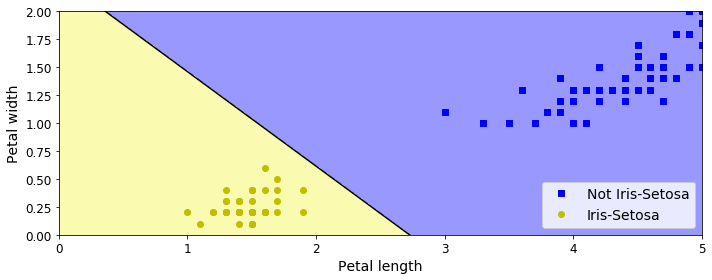

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    ) # creates the meshgrid
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-")
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Function to create a neuron layer
Unfortunately this has been deprecated due to getshape() not being a thing anymore so, moving on!

In [6]:
# def neuron_layer(X, n_neurons, name, activation=None):
#     with tf.name_scope(name):
#         # get the number of inputs by getting the input shape
#         n_inputs = int(tf.reshape(X.getshape()[1])
#         # getting size of second dimension
#         stdev = 2 / np.sqrt(n_inputs)
#         # 2D tensor connecting weights between each 
#         init = tf.truncated_normal((n_inputs, n_nerons))
#         # hold the weights (called the layer kernel)
#         W = tf.Variable(init, name="kernel")
#         # creates bias initalized to 0
#         b = tf.Variable(tf.zeros([n_neurons]), name="bias")
#         # weights of sums of the imputs plus the bias term for each and every neuron (Z = X * W + b) 
#         Z = tf.matmul(X, W) + b
        
#         if activation is not None:
#             return activation(Z)
#         else:
#             return Z

# Using dense() instead of neuron_layer()

In [7]:
# init ndarrays from data
train_X, test_X, train_y, test_y = get_iris_data()

# Layer's sizes
n_inputs = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
n_hidden1 = 256                # Number of hidden nodes
# n_hidden# able to create additonal layers here
# n_hidden2 = 100
n_outputs = train_y.shape[1]   # Number of outcomes (3 iris flowers)

In [8]:
reset_graph()

# Symbols
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# Create neuron layers
with tf.name_scope("dnn"):
#     hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
# hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
# logits = neuron_layer(hidden2, n_outputs, name="outputs")
# logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    print(logits)

Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)


In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [10]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
predict = tf.argmax(logits, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Train model

In [14]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(100):
        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

sess.close()

Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Epoch = 6, train accuracy = 92.00%, test accuracy = 94.00%
Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Epoch = 17, train accuracy = 96.00%, test accurac

# Full Experiment

In [15]:
import pandas as pd

# Experiment with layers 1 to 256
for hidden_layer in range(1,257):
    reset_graph()
    
    # init ndarrays from data
    train_X, test_X, train_y, test_y = get_iris_data()

    # Layer's sizes
    n_inputs = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    n_hidden1 = hidden_layer       # Number of hidden nodes
    n_outputs = train_y.shape[1]   # Number of outcomes (3 iris flowers)

    # Symbols
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    
    # Create neuron layers
    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
        logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
        print(logits)
        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)
    
    # loss
    with tf.name_scope("loss"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
    
    # train
    learning_rate = 0.01

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
    
    # evaluate
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    predict = tf.argmax(logits, axis=1)

    # Backward propagation
    cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    df = pd.DataFrame()
    
    for epoch in range(100):
            # Train with each example
            for i in range(len(train_X)):
                sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

            train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                     sess.run(predict, feed_dict={X: train_X, y: train_y}))
            test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                     sess.run(predict, feed_dict={X: test_X, y: test_y}))

            print("Hidden Layers = %d, Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
                  % (hidden_layer, epoch + 1, 100. * train_accuracy, 100. * test_accuracy))
    sess.close()
    print("="*100)
                      

Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 1, Epoch = 1, train accuracy = 36.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 2, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 3, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 4, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 5, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 6, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 1, Epoch = 7, train accuracy = 35.00%, test accuracy = 32.00%
Hidden Layers = 1, Epoch = 8, train accuracy = 35.00%, test accuracy = 32.00%
Hidden Layers = 1, Epoch = 9, train accuracy = 35.00%, test accuracy = 32.00%
Hidden Layers = 1, Epoch = 10, train accuracy = 35.00%, test accuracy = 32.00%
Hidden Layers = 1, Epoch = 11, train accuracy = 35.00%, test accuracy = 32.00%
Hidden Layers = 1, Epoch = 12, train accuracy = 35.00%, test accuracy = 32.00%


Hidden Layers = 2, Epoch = 2, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 3, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 4, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 5, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 6, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 7, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 8, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 9, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 10, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 11, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 12, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 13, train accuracy = 35.00%, test accuracy = 30.00%
Hidden Layers = 2, Epoch = 14, train accuracy = 35.00%, test

Hidden Layers = 3, Epoch = 10, train accuracy = 69.00%, test accuracy = 70.00%
Hidden Layers = 3, Epoch = 11, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 3, Epoch = 12, train accuracy = 69.00%, test accuracy = 74.00%
Hidden Layers = 3, Epoch = 13, train accuracy = 70.00%, test accuracy = 74.00%
Hidden Layers = 3, Epoch = 14, train accuracy = 71.00%, test accuracy = 76.00%
Hidden Layers = 3, Epoch = 15, train accuracy = 74.00%, test accuracy = 78.00%
Hidden Layers = 3, Epoch = 16, train accuracy = 75.00%, test accuracy = 78.00%
Hidden Layers = 3, Epoch = 17, train accuracy = 75.00%, test accuracy = 78.00%
Hidden Layers = 3, Epoch = 18, train accuracy = 78.00%, test accuracy = 78.00%
Hidden Layers = 3, Epoch = 19, train accuracy = 80.00%, test accuracy = 80.00%
Hidden Layers = 3, Epoch = 20, train accuracy = 81.00%, test accuracy = 82.00%
Hidden Layers = 3, Epoch = 21, train accuracy = 83.00%, test accuracy = 82.00%
Hidden Layers = 3, Epoch = 22, train accuracy = 85.0

Hidden Layers = 4, Epoch = 13, train accuracy = 72.00%, test accuracy = 76.00%
Hidden Layers = 4, Epoch = 14, train accuracy = 74.00%, test accuracy = 78.00%
Hidden Layers = 4, Epoch = 15, train accuracy = 75.00%, test accuracy = 80.00%
Hidden Layers = 4, Epoch = 16, train accuracy = 80.00%, test accuracy = 82.00%
Hidden Layers = 4, Epoch = 17, train accuracy = 85.00%, test accuracy = 82.00%
Hidden Layers = 4, Epoch = 18, train accuracy = 88.00%, test accuracy = 84.00%
Hidden Layers = 4, Epoch = 19, train accuracy = 90.00%, test accuracy = 86.00%
Hidden Layers = 4, Epoch = 20, train accuracy = 91.00%, test accuracy = 88.00%
Hidden Layers = 4, Epoch = 21, train accuracy = 91.00%, test accuracy = 90.00%
Hidden Layers = 4, Epoch = 22, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 4, Epoch = 23, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 4, Epoch = 24, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 4, Epoch = 25, train accuracy = 92.0

Hidden Layers = 5, Epoch = 19, train accuracy = 96.00%, test accuracy = 90.00%
Hidden Layers = 5, Epoch = 20, train accuracy = 97.00%, test accuracy = 90.00%
Hidden Layers = 5, Epoch = 21, train accuracy = 97.00%, test accuracy = 90.00%
Hidden Layers = 5, Epoch = 22, train accuracy = 94.00%, test accuracy = 90.00%
Hidden Layers = 5, Epoch = 23, train accuracy = 97.00%, test accuracy = 96.00%
Hidden Layers = 5, Epoch = 24, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 5, Epoch = 25, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 5, Epoch = 26, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 5, Epoch = 27, train accuracy = 97.00%, test accuracy = 96.00%
Hidden Layers = 5, Epoch = 28, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 5, Epoch = 29, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 5, Epoch = 30, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 5, Epoch = 31, train accuracy = 98.

Hidden Layers = 6, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 6, Epoch = 42, train accuracy = 97.0

Hidden Layers = 7, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 7, Epoch = 52, train accuracy = 97.0

Hidden Layers = 8, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 8, Epoch = 56, train accuracy = 97.0

Hidden Layers = 9, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 9, Epoch = 61, train accuracy = 97.0

Hidden Layers = 10, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 66, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 67, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 68, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 69, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 10, Epoch = 70, train ac

Hidden Layers = 11, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 11, Epoch = 76, train ac

Hidden Layers = 12, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 12, Epoch = 79, train ac

Hidden Layers = 13, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 81, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 82, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 83, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 13, Epoch = 85, train ac

Hidden Layers = 14, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 81, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 82, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 83, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 14, Epoch = 87, train ac

Hidden Layers = 15, Epoch = 84, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 85, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 86, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 15, Epoch = 96, train ac

Hidden Layers = 16, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 16, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(

Hidden Layers = 17, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 17, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 18, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 18, Epoch = 2, train accuracy = 65.00%, tes

Hidden Layers = 18, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 18, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 19, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 19, Epoch = 2, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 19, Epoch = 3, train accuracy = 70.00%, test accuracy = 74.00%
Hidden Layers = 19, Epoch = 4, train accuracy = 81.00%, test accuracy = 84.00%
Hidden Layers = 19, Epoch = 5, train accuracy = 86.00%, test accuracy = 88.00%
Hidden Layers = 19, Epoch = 6, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 19, Epoch = 7, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 19, Epoch = 8, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 19, Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 19, Epoch = 10, train accuracy = 93.00%, test accur

Hidden Layers = 20, Epoch = 2, train accuracy = 67.00%, test accuracy = 72.00%
Hidden Layers = 20, Epoch = 3, train accuracy = 80.00%, test accuracy = 86.00%
Hidden Layers = 20, Epoch = 4, train accuracy = 85.00%, test accuracy = 90.00%
Hidden Layers = 20, Epoch = 5, train accuracy = 90.00%, test accuracy = 90.00%
Hidden Layers = 20, Epoch = 6, train accuracy = 90.00%, test accuracy = 94.00%
Hidden Layers = 20, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 20, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 20, Epoch = 14, train accuracy =

Hidden Layers = 21, Epoch = 10, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 21, Epoch = 11, train accuracy = 93.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 12, train accuracy = 94.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 13, train accuracy = 94.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 14, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 15, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 16, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 17, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 18, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 19, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 21, Epoch = 2

Hidden Layers = 22, Epoch = 19, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 20, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 21, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 22, train accuracy = 95.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 25, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 26, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 27, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 28, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 29, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 30, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 22, Epoch = 

Hidden Layers = 23, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 23, Epoch = 40, train ac

Hidden Layers = 24, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 24, Epoch = 45, train ac

Hidden Layers = 25, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 25, Epoch = 54, train ac

Hidden Layers = 26, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 26, Epoch = 64, train ac

Hidden Layers = 27, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 27, Epoch = 67, train ac

Hidden Layers = 28, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 28, Epoch = 75, train ac

Hidden Layers = 29, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 29, Epoch = 80, train ac

Hidden Layers = 30, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 81, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 30, Epoch = 82, train ac

Hidden Layers = 31, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 31, Epoch = 87, train ac

Hidden Layers = 32, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 32, Epoch = 92, train ac

Hidden Layers = 33, Epoch = 87, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 88, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 89, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 90, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 91, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 92, train accuracy = 98.00%, test accuracy = 100.00%
Hidden Layers = 33, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 33, Epoch = 99, tr

Hidden Layers = 34, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 95, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 34, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 35, Epoch = 1, train accuracy = 66.00%, test accuracy = 70.00%
Hidden Layers = 35, Epoch = 2, train accuracy = 70.00%, test accuracy = 76.00%
Hidden Layers = 35, Epoch = 3, train accuracy = 81.00%, test accuracy = 86.00%
Hidden Layers = 35, Epoch = 4, train accuracy = 85.00%, test accuracy = 90.00%
Hidden Layers = 35, Epoch = 5, train accuracy = 90.00%, test a

Hidden Layers = 36, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 36, Epoch = 2, train accuracy = 66.00%, test accuracy = 72.00%
Hidden Layers = 36, Epoch = 3, train accuracy = 72.00%, test accuracy = 80.00%
Hidden Layers = 36, Epoch = 4, train accuracy = 82.00%, test accuracy = 86.00%
Hidden Layers = 36, Epoch = 5, train accuracy = 86.00%, test accuracy = 90.00%
Hidden Layers = 36, Epoch = 6, train accuracy = 89.00%, test accuracy = 90.00%
Hidden Layers = 36, Epoch = 7, train accuracy = 91.00%, test accuracy = 94.00%
Hidden Layers = 36, Epoch = 8, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 36, Epoch = 9, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 36, Epoch = 10, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 36, Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 36, Epoch = 12, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 36, Epoch = 13, train accuracy = 

Hidden Layers = 37, Epoch = 6, train accuracy = 89.00%, test accuracy = 92.00%
Hidden Layers = 37, Epoch = 7, train accuracy = 91.00%, test accuracy = 94.00%
Hidden Layers = 37, Epoch = 8, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 37, Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 13, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 14, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 37, Epoch = 18, train accura

Hidden Layers = 38, Epoch = 13, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 38, Epoch = 14, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 38, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 38, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 38, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 38, Epoch = 18, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 19, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 22, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 38, Epoch = 25, t

Hidden Layers = 39, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 22, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 25, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 26, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 27, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 28, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 29, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 30, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 31, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 39, Epoch = 

Hidden Layers = 40, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 28, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 29, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 30, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 31, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 32, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 33, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 40, Epoch = 36, train ac

Hidden Layers = 41, Epoch = 30, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 31, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 41, Epoch = 42, train ac

Hidden Layers = 42, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 42, Epoch = 50, train ac

Hidden Layers = 43, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 43, Epoch = 61, train ac

Hidden Layers = 44, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 44, Epoch = 70, train ac

Hidden Layers = 45, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 45, Epoch = 79, train ac

Hidden Layers = 46, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 81, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 82, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 46, Epoch = 88, train ac

Hidden Layers = 47, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 80, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 81, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 82, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 83, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 84, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 85, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 86, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 87, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 88, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 47, Epoch = 89, train ac

Hidden Layers = 48, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 48, Epoch = 93, train ac

Hidden Layers = 49, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 49, Epoch = 100, train a

Hidden Layers = 50, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 50, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 51, Epoch = 1, train accuracy = 65.00%, te

Hidden Layers = 51, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 51, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 51, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 52, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 52, Epoch = 2, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 52, Epoch = 3, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 52, Epoch = 4, train accuracy = 76.00%, test accuracy = 82.00%
Hidden Layers = 52, Epoch = 5, train accuracy = 83.00%, test accuracy = 88.00%
Hidden Layers = 52, Epoch = 6, train accuracy = 89.00%, test accuracy = 90.00%
Hidden Layers = 52, Epoch = 7, train accuracy = 90.00%, test accuracy = 94.00%
Hidden Layers = 52, Epoch = 8, train accuracy = 90.00%, test accuracy = 98.00%
Hidden Layers = 52, Epoch = 9, train accuracy = 94.00%, test accur

Hidden Layers = 53, Epoch = 1, train accuracy = 66.00%, test accuracy = 70.00%
Hidden Layers = 53, Epoch = 2, train accuracy = 79.00%, test accuracy = 82.00%
Hidden Layers = 53, Epoch = 3, train accuracy = 87.00%, test accuracy = 88.00%
Hidden Layers = 53, Epoch = 4, train accuracy = 90.00%, test accuracy = 88.00%
Hidden Layers = 53, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 53, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 53, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 53, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 53, Epoch = 9, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 53, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 53, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 53, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 53, Epoch = 13, train accuracy = 

Hidden Layers = 54, Epoch = 10, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 54, Epoch = 11, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 12, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 13, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 14, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 15, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 54, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 54, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 54, Epoch = 22, train 

Hidden Layers = 55, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 22, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 25, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 26, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 27, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 28, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 29, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 30, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 31, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 55, Epoch = 

Hidden Layers = 56, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 56, Epoch = 42, train ac

Hidden Layers = 57, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 57, Epoch = 46, train ac

Hidden Layers = 58, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 58, Epoch = 47, train ac

Hidden Layers = 59, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 59, Epoch = 50, train ac

Hidden Layers = 60, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 60, Epoch = 55, train ac

Hidden Layers = 61, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 61, Epoch = 61, train ac

Hidden Layers = 62, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 62, Epoch = 64, train ac

Hidden Layers = 63, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 63, Epoch = 69, train ac

Hidden Layers = 64, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 64, Epoch = 72, train ac

Hidden Layers = 65, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 73, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 65, Epoch = 77, train ac

Hidden Layers = 66, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 66, Epoch = 82, train ac

Hidden Layers = 67, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 67, Epoch = 89, train ac

Hidden Layers = 68, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 68, Epoch = 98, train ac

Hidden Layers = 69, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 69, Epoch = 99, train ac

Hidden Layers = 70, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 70, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 70, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 70, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 70, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 70, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 71, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 71, Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 71, Epoch = 3, train accuracy = 78.00%, test accuracy = 84.00%
Hidden Layers = 71, Epoch = 4, train accuracy = 84.00%, test accuracy = 88.00%
Hidden Layers = 71, Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Hidden Layers = 71, Epoch = 6, train accuracy = 92.00%, test ac

Hidden Layers = 71, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 71, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 71, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 71, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 72, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 72, Epoch = 2, train accuracy = 69.00%, test accuracy = 74.00%
Hidden Layers = 72, Epoch = 3, train accuracy = 83.00%, test accuracy = 84.00%
Hidden Layers = 72, Epoch = 4, train accuracy = 87.00%, test accuracy = 88.00%
Hidden Layers = 72, Epoch = 5, train accuracy = 90.00%, test accuracy = 94.00%
Hidden Layers = 72, Epoch = 6, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 72, Epoch = 7, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 72, Epoch = 8, train accuracy = 94.00%, test accu

Hidden Layers = 73, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 73, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 73, Epoch = 3, train accuracy = 76.00%, test accuracy = 82.00%
Hidden Layers = 73, Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Hidden Layers = 73, Epoch = 5, train accuracy = 89.00%, test accuracy = 90.00%
Hidden Layers = 73, Epoch = 6, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 73, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 73, Epoch = 8, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 73, Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 73, Epoch = 10, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 73, Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 73, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 73, Epoch = 13, train accuracy = 

Hidden Layers = 74, Epoch = 10, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 74, Epoch = 22, train ac

Hidden Layers = 75, Epoch = 19, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 22, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 25, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 26, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 27, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 28, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 29, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 30, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 75, Epoch = 

Hidden Layers = 76, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 76, Epoch = 34, train ac

Hidden Layers = 77, Epoch = 28, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 29, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 30, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 31, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 32, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 33, train accuracy = 97.00%, test accuracy = 100.00%
Hidden Layers = 77, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 77, Epoch = 40, tr

Hidden Layers = 78, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 78, Epoch = 43, train ac

Hidden Layers = 79, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 79, Epoch = 47, train ac

Hidden Layers = 80, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 80, Epoch = 55, train ac

Hidden Layers = 81, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 81, Epoch = 58, train ac

Hidden Layers = 82, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 82, Epoch = 66, train ac

Hidden Layers = 83, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 83, Epoch = 75, train ac

Hidden Layers = 84, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 84, Epoch = 82, train ac

Hidden Layers = 85, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 85, Epoch = 84, train ac

Hidden Layers = 86, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 86, Epoch = 93, train ac

Hidden Layers = 87, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 87, Epoch = 99, train ac

Hidden Layers = 88, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 88, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 89, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 89, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 89, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 89, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 89, Epoch = 5, train accuracy = 89.00%, test a

Hidden Layers = 89, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 90, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 90, Epoch = 2, train accuracy = 69.00%, test accuracy = 70.00%
Hidden Layers = 90, Epoch = 3, train accuracy = 79.00%, test accuracy = 82.00%
Hidden Layers = 90, Epoch = 4, train accuracy = 83.00%, test accuracy = 88.00%
Hidden Layers = 90, Epoch = 5, train accuracy = 89.00%, test accuracy = 88.00%
Hidden Layers = 90, Epoch = 6, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 90, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 90, Epoch = 8, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 90, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 90, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 90, Epoch = 11, train accuracy = 94.00%, test accur

Hidden Layers = 91, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 91, Epoch = 2, train accuracy = 70.00%, test accuracy = 74.00%
Hidden Layers = 91, Epoch = 3, train accuracy = 82.00%, test accuracy = 84.00%
Hidden Layers = 91, Epoch = 4, train accuracy = 86.00%, test accuracy = 90.00%
Hidden Layers = 91, Epoch = 5, train accuracy = 91.00%, test accuracy = 94.00%
Hidden Layers = 91, Epoch = 6, train accuracy = 92.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 7, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 8, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 91, Epoch = 13, train accuracy = 

Hidden Layers = 92, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 92, Epoch = 23, train ac

Hidden Layers = 93, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 23, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 24, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 93, Epoch = 25, train ac

Hidden Layers = 94, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 94, Epoch = 27, train ac

Hidden Layers = 95, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 25, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 95, Epoch = 36, train ac

Hidden Layers = 96, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 96, Epoch = 44, train ac

Hidden Layers = 97, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 97, Epoch = 47, train ac

Hidden Layers = 98, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 98, Epoch = 52, train ac

Hidden Layers = 99, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 99, Epoch = 61, train ac

Hidden Layers = 100, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 100, Epoch =

Hidden Layers = 101, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 101, Epoch =

Hidden Layers = 102, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 102, Epoch =

Hidden Layers = 103, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 103, Epoch =

Hidden Layers = 104, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 104, Epoch =

Hidden Layers = 105, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 105, Epoch =

Hidden Layers = 106, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 106, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 107, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 107, Epoch = 2, train accuracy =

Hidden Layers = 107, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 107, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 107, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 108, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 108, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 108, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 108, Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Hidden Layers = 108, Epoch = 5, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 108, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 108, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 108, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 108, Epoch = 9, train accuracy = 94.00%

Hidden Layers = 109, Epoch = 3, train accuracy = 80.00%, test accuracy = 84.00%
Hidden Layers = 109, Epoch = 4, train accuracy = 88.00%, test accuracy = 88.00%
Hidden Layers = 109, Epoch = 5, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 109, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 109, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 109, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 109, Epoch = 15, tr

Hidden Layers = 110, Epoch = 10, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 13, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 110, Epoch =

Hidden Layers = 111, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 111, Epoch =

Hidden Layers = 112, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 28, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 29, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 112, Epoch =

Hidden Layers = 113, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 113, Epoch =

Hidden Layers = 114, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 114, Epoch =

Hidden Layers = 115, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 115, Epoch =

Hidden Layers = 116, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 116, Epoch =

Hidden Layers = 117, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 117, Epoch =

Hidden Layers = 118, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 118, Epoch =

Hidden Layers = 119, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 119, Epoch =

Hidden Layers = 120, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 120, Epoch =

Hidden Layers = 121, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 121, Epoch =

Hidden Layers = 122, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 122, Epoch =

Hidden Layers = 123, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 123, Epoch =

Hidden Layers = 124, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 72, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 73, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 124, Epoch =

Hidden Layers = 125, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 125, Epoch =

Hidden Layers = 126, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 126, Epoch =

Hidden Layers = 127, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 127, Epoch =

Hidden Layers = 128, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 128, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd

Hidden Layers = 129, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 129, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 129, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 129, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 130, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 130, Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 130, Epoch = 3, train accuracy = 79.00%, test accuracy = 82.00%
Hidden Layers = 130, Epoch = 4, train accuracy = 88.00%, test accuracy = 88.00%
Hidden Layers = 130, Epoch = 5, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 130, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 130, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 130, Epoch = 8, train accuracy = 93.00

Hidden Layers = 131, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 131, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 131, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 131, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 131, Epoch = 5, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 131, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 131, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 131, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 131, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 131, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 131, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 131, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 131, Epoch = 13, trai

Hidden Layers = 132, Epoch = 5, train accuracy = 90.00%, test accuracy = 94.00%
Hidden Layers = 132, Epoch = 6, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 132, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 132, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 12, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 132, Epoch = 17, 

Hidden Layers = 133, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 133, Epoch = 

Hidden Layers = 134, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 134, Epoch =

Hidden Layers = 135, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 135, Epoch =

Hidden Layers = 136, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 136, Epoch =

Hidden Layers = 137, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 137, Epoch =

Hidden Layers = 138, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 138, Epoch =

Hidden Layers = 139, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 25, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 139, Epoch =

Hidden Layers = 140, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 140, Epoch =

Hidden Layers = 141, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 141, Epoch =

Hidden Layers = 142, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 142, Epoch =

Hidden Layers = 143, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 143, Epoch =

Hidden Layers = 144, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 144, Epoch =

Hidden Layers = 145, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 145, Epoch =

Hidden Layers = 146, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 146, Epoch =

Hidden Layers = 147, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 147, Epoch =

Hidden Layers = 148, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 148, Epoch =

Hidden Layers = 149, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 149, Epoch =

Hidden Layers = 150, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 150, Epoch =

Hidden Layers = 151, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 151, Epoch =

Hidden Layers = 152, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 152, Epoch =

Hidden Layers = 153, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 153, Epoch =

Hidden Layers = 154, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 154, Epoch =

Hidden Layers = 155, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 155, Epoch =

Hidden Layers = 156, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 156, Epoch =

Hidden Layers = 157, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 157, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 157, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 157, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 157, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 158, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 158, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 158, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 158, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 158, Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Hidden Layers = 158, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 158, Epoch = 7, train accuracy = 93.0

Hidden Layers = 159, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 159, Epoch = 2, train accuracy = 68.00%, test accuracy = 70.00%
Hidden Layers = 159, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 159, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 159, Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Hidden Layers = 159, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 159, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 159, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 159, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 159, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 159, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 159, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 159, Epoch = 13, trai

Hidden Layers = 160, Epoch = 3, train accuracy = 81.00%, test accuracy = 84.00%
Hidden Layers = 160, Epoch = 4, train accuracy = 85.00%, test accuracy = 90.00%
Hidden Layers = 160, Epoch = 5, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 160, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 160, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 160, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 160, Epoch = 15, tr

Hidden Layers = 161, Epoch = 5, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 161, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 161, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 161, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 161, Epoch = 17, 

Hidden Layers = 162, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 162, Epoch =

Hidden Layers = 163, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 163, Epoch =

Hidden Layers = 164, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 28, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 164, Epoch =

Hidden Layers = 165, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 165, Epoch =

Hidden Layers = 166, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 28, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 166, Epoch =

Hidden Layers = 167, Epoch = 30, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 31, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 167, Epoch =

Hidden Layers = 168, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 168, Epoch =

Hidden Layers = 169, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 169, Epoch =

Hidden Layers = 170, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 170, Epoch =

Hidden Layers = 171, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 171, Epoch =

Hidden Layers = 172, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 172, Epoch =

Hidden Layers = 173, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 173, Epoch =

Hidden Layers = 174, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 174, Epoch =

Hidden Layers = 175, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 175, Epoch =

Hidden Layers = 176, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 176, Epoch =

Hidden Layers = 177, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 177, Epoch =

Hidden Layers = 178, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 178, Epoch =

Hidden Layers = 179, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 179, Epoch =

Hidden Layers = 180, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 180, Epoch =

Hidden Layers = 181, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 181, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 182, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 182, Epoch = 2, train accuracy = 69.00%, test accuracy = 74.00%
Hidden Layers = 182, Epoch = 3, train accuracy = 80.00%, test accuracy = 82.00%
Hidden Layers = 182, Epoch = 4, train accuracy = 8

Hidden Layers = 182, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 182, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 182, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 182, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 182, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 182, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 183, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 183, Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 183, Epoch = 3, train accuracy = 80.00%, test accuracy = 82.00%
Hidden Layers = 183, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 183, Epoch = 5, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 183, Epoch = 6, train accuracy = 92.

Hidden Layers = 184, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 184, Epoch = 2, train accuracy = 67.00%, test accuracy = 70.00%
Hidden Layers = 184, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 184, Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Hidden Layers = 184, Epoch = 5, train accuracy = 90.00%, test accuracy = 90.00%
Hidden Layers = 184, Epoch = 6, train accuracy = 92.00%, test accuracy = 92.00%
Hidden Layers = 184, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 184, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 184, Epoch = 9, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 184, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 184, Epoch = 11, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 184, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 184, Epoch = 13, trai

Hidden Layers = 185, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 185, Epoch = 2, train accuracy = 70.00%, test accuracy = 74.00%
Hidden Layers = 185, Epoch = 3, train accuracy = 80.00%, test accuracy = 82.00%
Hidden Layers = 185, Epoch = 4, train accuracy = 88.00%, test accuracy = 88.00%
Hidden Layers = 185, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 185, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 185, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 8, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 185, Epoch = 13, trai

Hidden Layers = 186, Epoch = 2, train accuracy = 70.00%, test accuracy = 74.00%
Hidden Layers = 186, Epoch = 3, train accuracy = 82.00%, test accuracy = 84.00%
Hidden Layers = 186, Epoch = 4, train accuracy = 88.00%, test accuracy = 90.00%
Hidden Layers = 186, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 186, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 186, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 8, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 186, Epoch = 14, tra

Hidden Layers = 187, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 187, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 187, Epoch = 18,

Hidden Layers = 188, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 188, Epoch =

Hidden Layers = 189, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 27, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 28, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 189, Epoch =

Hidden Layers = 190, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 190, Epoch =

Hidden Layers = 191, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 191, Epoch =

Hidden Layers = 192, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 192, Epoch =

Hidden Layers = 193, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 193, Epoch =

Hidden Layers = 194, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 194, Epoch =

Hidden Layers = 195, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 195, Epoch =

Hidden Layers = 196, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 196, Epoch =

Hidden Layers = 197, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 197, Epoch =

Hidden Layers = 198, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 198, Epoch =

Hidden Layers = 199, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 199, Epoch =

Hidden Layers = 200, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 200, Epoch =

Hidden Layers = 201, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 201, Epoch =

Hidden Layers = 202, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 73, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 74, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 202, Epoch =

Hidden Layers = 203, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 203, Epoch =

Hidden Layers = 204, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 204, Epoch =

Hidden Layers = 205, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 205, Epoch =

Hidden Layers = 206, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 206, Epoch =

Hidden Layers = 207, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 207, Epoch =

Hidden Layers = 208, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 208, Epoch =

Hidden Layers = 209, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 209, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 210, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 210, Epoch = 2, train accuracy =

Hidden Layers = 210, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 210, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 210, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 210, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 210, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 211, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 211, Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 211, Epoch = 3, train accuracy = 80.00%, test accuracy = 84.00%
Hidden Layers = 211, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 211, Epoch = 5, train accuracy = 91.00%, test accuracy = 92.00%
Hidden Layers = 211, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 211, Epoch = 7, train accuracy = 93.0

Hidden Layers = 211, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 211, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 211, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 212, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 212, Epoch = 2, train accuracy = 70.00%, test accuracy = 78.00%
Hidden Layers = 212, Epoch = 3, train accuracy = 82.00%, test accuracy = 86.00%
Hidden Layers = 212, Epoch = 4, train accuracy = 87.00%, test accuracy = 90.00%
Hidden Layers = 212, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 212, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 212, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 212, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 212, Epoch = 9, train accuracy = 94.00%

Hidden Layers = 213, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 213, Epoch = 2, train accuracy = 67.00%, test accuracy = 72.00%
Hidden Layers = 213, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 213, Epoch = 4, train accuracy = 84.00%, test accuracy = 88.00%
Hidden Layers = 213, Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Hidden Layers = 213, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 213, Epoch = 7, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 213, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 213, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 213, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 213, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 213, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 213, Epoch = 13, trai

Hidden Layers = 214, Epoch = 3, train accuracy = 81.00%, test accuracy = 82.00%
Hidden Layers = 214, Epoch = 4, train accuracy = 85.00%, test accuracy = 88.00%
Hidden Layers = 214, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 214, Epoch = 6, train accuracy = 92.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 7, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 8, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 11, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 214, Epoch = 15, tr

Hidden Layers = 215, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 215, Epoch =

Hidden Layers = 216, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 216, Epoch =

Hidden Layers = 217, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 217, Epoch =

Hidden Layers = 218, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 23, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 24, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 25, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 26, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 218, Epoch =

Hidden Layers = 219, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 219, Epoch =

Hidden Layers = 220, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 220, Epoch =

Hidden Layers = 221, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 221, Epoch =

Hidden Layers = 222, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 222, Epoch =

Hidden Layers = 223, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 223, Epoch =

Hidden Layers = 224, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 224, Epoch =

Hidden Layers = 225, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 225, Epoch =

Hidden Layers = 226, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 226, Epoch =

Hidden Layers = 227, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 227, Epoch =

Hidden Layers = 228, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch = 75, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 228, Epoch =

Hidden Layers = 229, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch = 79, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 229, Epoch =

Hidden Layers = 230, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 230, Epoch =

Hidden Layers = 231, Epoch = 77, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 78, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 231, Epoch =

Hidden Layers = 232, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 232, Epoch =

Hidden Layers = 233, Epoch = 82, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 233, Epoch =

Hidden Layers = 234, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 90, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 91, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 92, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 93, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 94, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 95, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 234, Epoch =

Hidden Layers = 235, Epoch = 96, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 235, Epoch = 97, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 235, Epoch = 98, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 235, Epoch = 99, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 235, Epoch = 100, train accuracy = 98.00%, test accuracy = 98.00%
Tensor("dnn/outputs/BiasAdd:0", shape=(?, 3), dtype=float32)
Hidden Layers = 236, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 236, Epoch = 2, train accuracy = 69.00%, test accuracy = 72.00%
Hidden Layers = 236, Epoch = 3, train accuracy = 78.00%, test accuracy = 82.00%
Hidden Layers = 236, Epoch = 4, train accuracy = 84.00%, test accuracy = 86.00%
Hidden Layers = 236, Epoch = 5, train accuracy = 90.00%, test accuracy = 92.00%
Hidden Layers = 236, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 236, Epoch = 7, train accuracy = 92.0

Hidden Layers = 237, Epoch = 1, train accuracy = 65.00%, test accuracy = 70.00%
Hidden Layers = 237, Epoch = 2, train accuracy = 70.00%, test accuracy = 76.00%
Hidden Layers = 237, Epoch = 3, train accuracy = 82.00%, test accuracy = 84.00%
Hidden Layers = 237, Epoch = 4, train accuracy = 89.00%, test accuracy = 90.00%
Hidden Layers = 237, Epoch = 5, train accuracy = 92.00%, test accuracy = 94.00%
Hidden Layers = 237, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 237, Epoch = 7, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 8, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 10, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 237, Epoch = 13, trai

Hidden Layers = 238, Epoch = 6, train accuracy = 92.00%, test accuracy = 96.00%
Hidden Layers = 238, Epoch = 7, train accuracy = 93.00%, test accuracy = 96.00%
Hidden Layers = 238, Epoch = 8, train accuracy = 93.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 9, train accuracy = 94.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 10, train accuracy = 95.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 11, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 12, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 238, Epoch = 18,

Hidden Layers = 239, Epoch = 13, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 14, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 15, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 16, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 17, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 18, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 239, Epoch = 19, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, Epoch = 20, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, Epoch = 21, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, Epoch = 22, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, Epoch = 23, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, Epoch = 24, train accuracy = 96.00%, test accuracy = 100.00%
Hidden Layers = 239, E

Hidden Layers = 240, Epoch = 19, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 20, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 21, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 22, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 240, Epoch =

Hidden Layers = 241, Epoch = 23, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 24, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 25, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 26, train accuracy = 96.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 27, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 28, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 29, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 241, Epoch =

Hidden Layers = 242, Epoch = 30, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 31, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 32, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 242, Epoch =

Hidden Layers = 243, Epoch = 33, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 243, Epoch =

Hidden Layers = 244, Epoch = 34, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 244, Epoch =

Hidden Layers = 245, Epoch = 35, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 36, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 37, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 38, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 39, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 40, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 245, Epoch =

Hidden Layers = 246, Epoch = 41, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 42, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 43, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 246, Epoch =

Hidden Layers = 247, Epoch = 44, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 45, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 46, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 47, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 48, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 247, Epoch =

Hidden Layers = 248, Epoch = 49, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 50, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 248, Epoch =

Hidden Layers = 249, Epoch = 51, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 249, Epoch =

Hidden Layers = 250, Epoch = 52, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 53, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 54, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 55, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 56, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 57, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 58, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 59, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 60, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 250, Epoch =

Hidden Layers = 251, Epoch = 61, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 62, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 63, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 64, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 65, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 66, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 67, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 68, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 69, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 251, Epoch =

Hidden Layers = 252, Epoch = 70, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 71, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 72, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 73, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 252, Epoch =

Hidden Layers = 253, Epoch = 74, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 75, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 253, Epoch =

Hidden Layers = 254, Epoch = 76, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 254, Epoch =

Hidden Layers = 255, Epoch = 76, train accuracy = 97.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 77, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 255, Epoch =

Hidden Layers = 256, Epoch = 78, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 79, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 80, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 81, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 82, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 83, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 84, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 85, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 86, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 87, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 88, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch = 89, train accuracy = 98.00%, test accuracy = 98.00%
Hidden Layers = 256, Epoch =